## Vorlesung Automones Fahren, HS Esslingen, Thao Dang

# Merkmalsextraktion für Spurverlaufsschätzung

## Vorbereitungen

In diesem Notebook sollen Sie Markierungspunkte auf den linken und rechten Spurberandungen detektieren.
Diese Markierungen sollen in der nächsten Laboreinheit dann zur Spurverlaufsschätzung mit LS-Schätzern dienen. Sie entwerfen und testen Ihren Algorithmus zunächst an Beispielbildern aus der Simulation. Asnchliessend übertragen Sie Ihr Verfahren in ROS.

Upload zu Colab (falls nötig) und laden der Standard-Bibliotheken:

In [ ]:
# Upload images - Colab ONLY!
# lane_detection_loop_20.png, lane_detection_loop_60.png, lane_detection_loop_80.png, simulation_image_helper.py
"""
try:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

except:
    print('Not using Colab or error uploading files.')
"""

Saving lane_detection_loop_20.png to lane_detection_loop_20.png
Saving lane_detection_loop_60.png to lane_detection_loop_60.png
Saving lane_detection_loop_80.png to lane_detection_loop_80.png
Saving simulation_image_helper.py to simulation_image_helper.py
User uploaded file "lane_detection_loop_20.png" with length 287213 bytes
User uploaded file "lane_detection_loop_60.png" with length 281455 bytes
User uploaded file "lane_detection_loop_80.png" with length 280899 bytes
User uploaded file "simulation_image_helper.py" with length 4306 bytes


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from simulation_image_helper import SimulationImageHelper

Als nächstes Laden wir ein Beispielbild (Sie können das Beispielbild später wechseln):

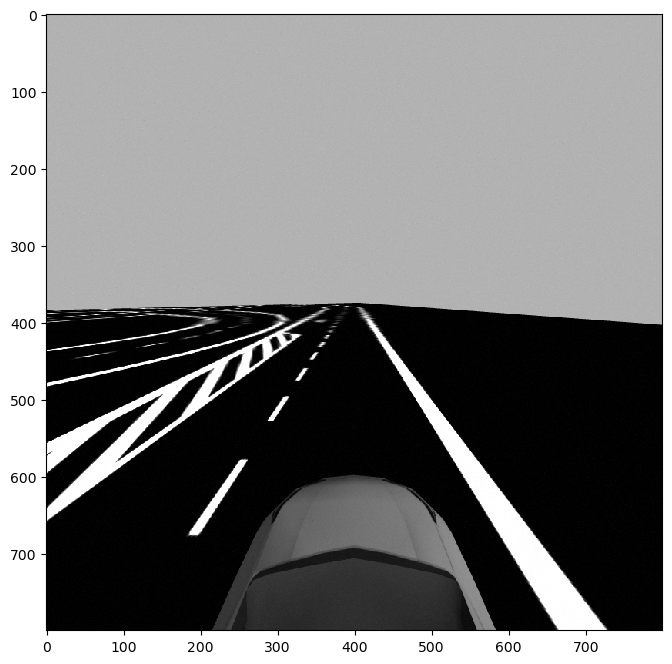

In [3]:
im = cv2.imread('lane_detection_loop_20.png')
#im = cv2.imread('lane_detection_loop_60.png')
#im = cv2.imread('lane_detection_loop_80.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='gray');

## Extraktion der Markierungspunkte im Bild

Entwerfen Sie zunächst ein Verfahren, dass mögliche Markierungspunkte im Bild erkennt. In der Wahl des Verfahrens sind Sie dabei frei. Sie können z.B. dunkel-hell-dunkel-Übergänge suchen, einen Canny-Edge-Detector verwenden, etc.

Visualisieren Sie Ihre Ergebnisse und testen Sie auf mehreren Bildern.

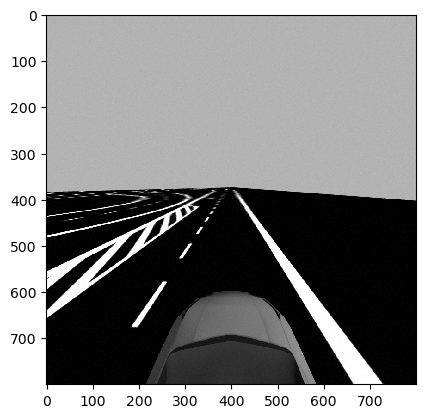

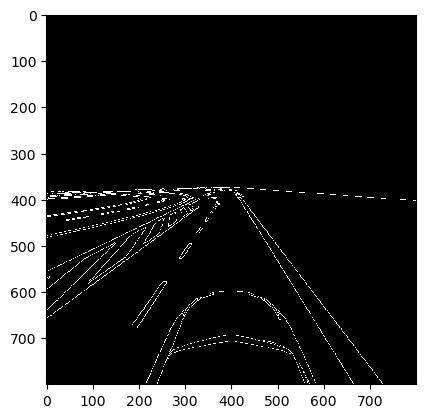

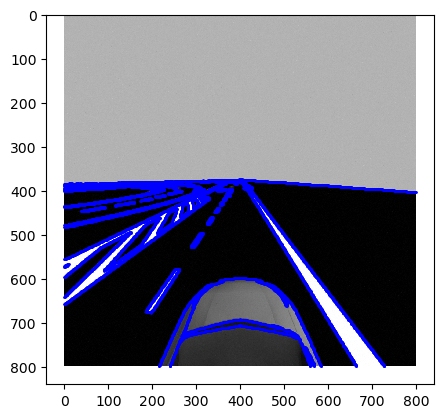

In [45]:
plt.figure()
plt.imshow(im, cmap='gray')
plt.show()

edges = cv2.Canny(im, 50, 150)

plt.figure()
plt.imshow(edges, cmap='gray')
plt.show()

y, x = np.where(edges > 0)
points = np.column_stack((x, y))

plt.imshow(im, cmap='gray')
plt.scatter(points[:,0], points[:,1], s=1, c='blue')

plt.show()

## Transformation in Vogelperspektive

Die detektierten Bildkoordinaten müssen Sie als nächstes in ein DIN70000-Koordinatensystem transformieren. Verwenden Sie dazu das Modul ``simulation_image_helper.py``. Am Ende dieses Moduls sind Beispiele für die Verwendung der bereitgestellten Funktionen zu finden.

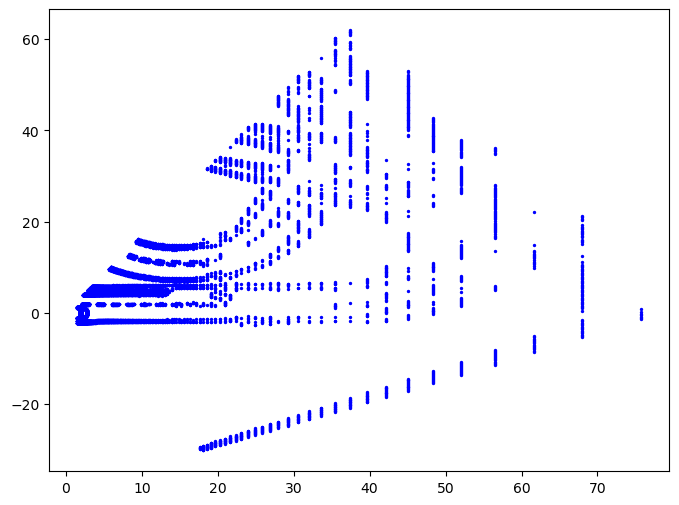

In [46]:
helper = SimulationImageHelper()
roadPoints = helper.image2road(points)
roadPoints = np.asarray(roadPoints).reshape(-1, 2)

plt.figure(figsize=(8,6))
plt.scatter(roadPoints[:,0], roadPoints[:,1], s=2, c='blue')

lane_left  = roadPoints[roadPoints[:,1] > 0] # -- linke spur
lane_right = roadPoints[roadPoints[:,1] < 0] # -- rechte spur

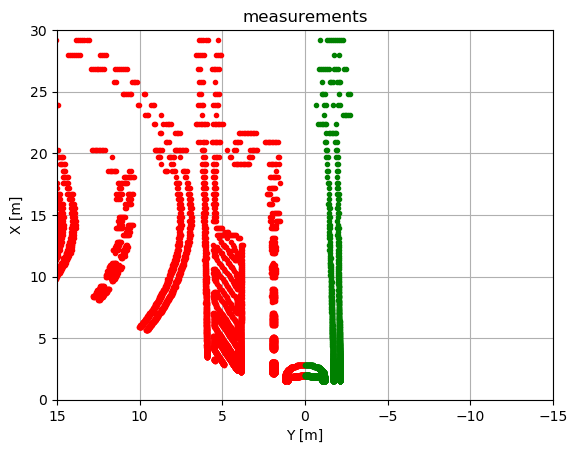

In [47]:
# Code zum Darstellen der Markierungspunkte in der Vogelperspektive
plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'r.')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'g.')
plt.xlim(15, -15)
plt.xlabel('Y [m]')
plt.ylim(0, 30)
plt.ylabel('X [m]')
plt.grid(True);

Found 1740 inliers (of 2017 total points).


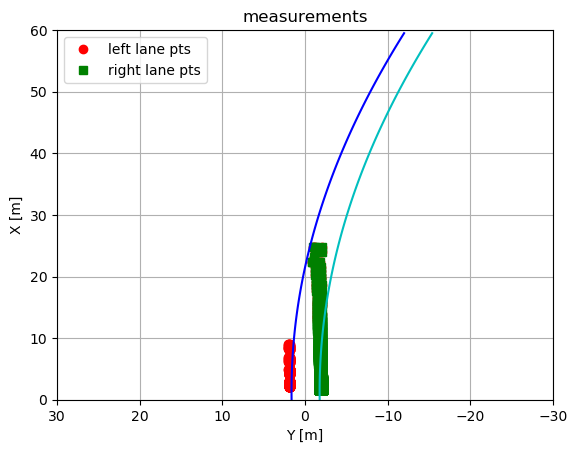

In [ ]:
import time

def LS_lane_fit(pL, pR):
    """
    LS estimate for lane coeffients z=(W, Y_offset, Delta_Phi, c0)^T.

    Args:
        pL: [NL, 2]-array of left marking positions (in DIN70000)
        pR: [NR, 2]-array of right marking positions (in DIN70000)

    Returns:
        Z: lane coeffients (W, Y_offset, Delta_Phi, c0)
    """

    H = np.zeros((pL.shape[0]+pR.shape[0], 4)) # design matrix
    Y = np.zeros((pL.shape[0]+pR.shape[0], 1)) # noisy observations

    # fill H and Y for left line points
    for i in range(pL.shape[0]):
        u, v = pL[i,0], pL[i,1]
        u2 = u*u
        H[i, :] = [0.5, -1, -u, 1.0/2.0 * u2]
        Y[i] = v

    # fill H and Y for right line points
    for i in range(pR.shape[0]):
        u, v = pR[i,0], pR[i,1]
        u2 = u*u
        u3 = u2*u
        H[pL.shape[0]+i, :] = [-0.5, -1, -u, 1.0/2.0 * u2]
        Y[pL.shape[0]+i] = v

    # compute optimal state vector Z
    Z = np.dot(np.linalg.pinv(H), Y)

    return Z


def LS_lane_compute(Z, maxDist=60, step=0.5):
    """
    Compute lane points from given parameter vector.

    Args;
        Z: lane coeffients (W, Y_offset, Delta_Phi, c0)
        maxDist[=60]: distance up to which lane shall be computed
        step[=0.5]: step size in x-direction (in m)

    Returns:
        (x_pred, yl_pred, yr_pred): x- and y-positions of left and
            right lane points
    """
    x_pred = np.arange(0, maxDist, step)
    yl_pred = np.zeros_like(x_pred)
    yr_pred = np.zeros_like(x_pred)

    for i in range(x_pred.shape[0]):
        u = x_pred[i]
        u2 = u*u
        yl_pred[i] = np.dot( np.array([ 0.5, -1, -u, 1.0/2.0 * u2]), Z )
        yr_pred[i] = np.dot( np.array([-0.5, -1, -u, 1.0/2.0 * u2]), Z )

    return (x_pred, yl_pred, yr_pred)

Z_all = LS_lane_fit(lane_left, lane_right)
x_pred, yl_pred, yr_pred = LS_lane_compute(Z_all)

plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'ro', label='left lane pts')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'gs', label='right lane pts')
plt.legend()
plt.plot(yl_pred, x_pred, 'b')
plt.plot(yr_pred, x_pred, 'c')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);
def LS_lane_residuals(lane_left, lane_right, Z):


    ## HIER CODE EINFUEGEN
    H = np.zeros((lane_left.shape[0]+lane_right.shape[0], 4)) # design matrix
    Y = np.zeros((lane_left.shape[0]+lane_right.shape[0], 1))

    for i in range(lane_left.shape[0]):
        u, v = lane_left[i,0], lane_left[i,1]
        u2 = u*u
        H[i, :] = [0.5, -1, -u, 1.0/2.0 * u2]
        Y[i] = v

    for i in range(lane_right.shape[0]):
        u, v = lane_right[i,0], lane_right[i,1]
        u2 = u*u
        u3 = u2*u
        H[lane_left.shape[0]+i, :] = [-0.5, -1, -u, 1.0/2.0 * u2]
        Y[lane_left.shape[0]+i] = v

    residual = np.dot(H, Z) - Y


    ## EIGENER CODE ENDE

    return residual


def LS_lane_inliers(residual, thresh):

    ## HIER CODE EINFUEGEN
    true_inliers = 0

    true_inliers = np.abs( residual ) < thresh
    n_inliners = np.sum(true_inliers)

    return n_inliners


    ## EIGENER CODE ENDE


# test with previous estimate
residual = LS_lane_residuals(lane_left, lane_right, Z_all)

print('Found %d inliers (of %d total points).' %
      (LS_lane_inliers(residual, 0.4), lane_left.shape[0]+lane_right.shape[0]))

## Laufzeit

Die Laufzeit Ihres Verfahrens ist später kritisch in ROS. Messen Sie die Laufzeit Ihres Verfahrens und überlegen Sie, wie Sie Ihr Verfahren schneller machen können.

99.13 ms


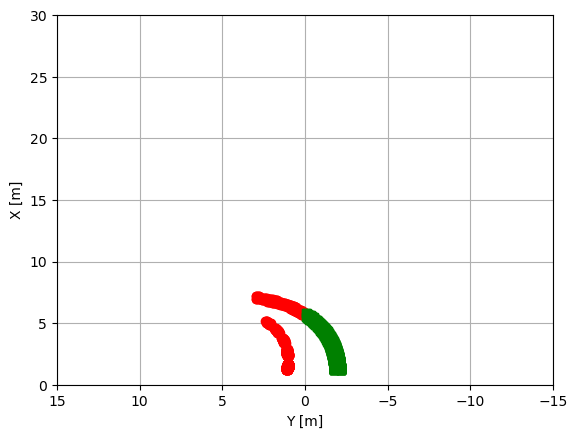

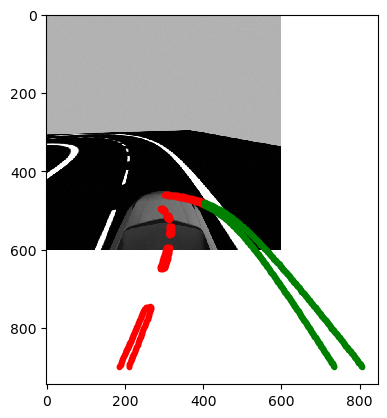

Current best solution:  [[2.93956381 0.62815993 0.1475081  0.16257298]]
with 1024 inliers (of 1599 measurements).


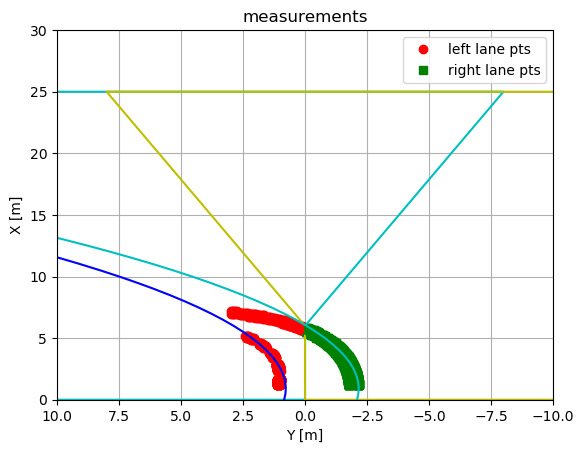

In [ ]:
import time
import random

S = 4
dist_thresh = 0.4
max_num_inliers = 0
Z_opt = None
num_iters = 30

#im = cv2.imread('lane_detection_loop_20.png')
#im = cv2.imread('lane_detection_loop_60.png')
im = cv2.imread('lane_detection_loop_80.png')

im = cv2.resize(im, (0,0), fx=0.75, fy=0.75)
starttime = time.perf_counter()
# ==================================================

edges = cv2.Canny(im, 50, 1000)
y, x = np.where(edges > 0)
points = np.column_stack((x, y)) * 1.5


roadPoints = helper.image2road(points)
roadPoints = np.asarray(roadPoints).reshape(-1, 2)

lane_width = 3
roadPoints = roadPoints[
    (roadPoints[:,1] > -lane_width) &
    (roadPoints[:,1] <  lane_width)
]


max_range_m = 25
roi_right_line = np.array([
    [0, 0],
    [6, 0],
    [max_range_m, 8],
    [max_range_m, -15],
    [0, -15] ])

roi_left_line = np.array([
    [0, 0],
    [6, 0],
    [max_range_m, -8],
    [max_range_m, 15],
    [0, 15] ])

M = roadPoints

lane_left = np.empty((0,2))
lane_right = np.empty((0,2))

for i in range(M.shape[0]):
    if cv2.pointPolygonTest(roi_left_line, (M[i,0], M[i,1]), False) > 0:
        lane_left = np.vstack((lane_left, M[i,:]))
    if cv2.pointPolygonTest(roi_right_line, (M[i,0], M[i,1]), False) > 0:
        lane_right = np.vstack((lane_right, M[i,:]))

lane_left_back = helper.road2image(lane_left)
imagePoints_back = np.asarray(lane_left_back).reshape(-1, 2)

lane_right_back = helper.road2image(lane_right)
imagePoints_back = np.asarray(lane_right_back).reshape(-1, 2)

for i in range(num_iters):
    # draw S//2 random indices for points in lane_left and lane_right, respectively
    idx_left = random.sample(range(lane_left.shape[0]), S//2)
    idx_right = random.sample(range(lane_right.shape[0]), S//2)

    ## HIER CODE EINFUEGEN
    Z_tmp = LS_lane_fit(lane_left[idx_left, :], lane_right[idx_right, :])
    residual = LS_lane_residuals(lane_left, lane_right, Z_tmp)
    inlier_mask = np.abs(residual) < dist_thresh
    num_inliers = LS_lane_inliers(residual, dist_thresh)
    if num_inliers > max_num_inliers:
        max_num_inliers = num_inliers
        Z_opt = Z_tmp

    # num_inliers = np.sum(inlier_mask)
    # if num_inliers > max_num_inliers:
    #     max_num_inliers = num_inliers
    #     Z_opt = Z_tmp
    #     best_inliers_mask = inlier_mask.copy()
    # ## EIGENER CODE ENDEi, (0
    # best_inliers_mask = best_inliers_mask.flatten()
    # nL = lane_left.shape[0]

    # mask_left = best_inliers_mask[:nL]
    # mask_right = best_inliers_mask[nL:]

    # lane_left_inliers = lane_left[mask_left, :]
    # lane_right_inliers = lane_right[mask_right, :]
    # Z_opt = LS_lane_fit(lane_left_inliers, lane_right_inliers)

    ## EIGENER CODE ENDE


x_pred, yl_pred, yr_pred = LS_lane_compute(Z_opt)

# ==================================================
stoptime = time.perf_counter()
duration = (stoptime - starttime) * 1000

print(f"{duration:.2f} ms")

plt.figure()
plt.plot(lane_left[:, 1], lane_left[:, 0], 'ro', label='left lane pts')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'gs', label='right lane pts')
plt.xlim(15, -15)
plt.xlabel('Y [m]')
plt.ylim(0, 30)
plt.ylabel('X [m]')
plt.grid(True)
plt.show()


plt.imshow(im, cmap='gray')
plt.plot(lane_left_back[:, 0], lane_left_back[:, 1], 'r.')
plt.plot(lane_right_back[:, 0], lane_right_back[:, 1], 'g.')
plt.show()


plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'ro', label='left lane pts')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'gs', label='right lane pts')
plt.legend()
plt.plot(roi_left_line[np.r_[0:roi_left_line.shape[0], 0], 1],
         roi_left_line[np.r_[0:roi_left_line.shape[0], 0], 0], 'c')
plt.plot(roi_right_line[np.r_[0:roi_right_line.shape[0], 0], 1],
         roi_right_line[np.r_[0:roi_right_line.shape[0], 0], 0], 'y')
plt.xlim(15, -15)
plt.xlabel('Y [m]')
plt.ylim(0, 30)
plt.ylabel('X [m]')
plt.grid(True);

y

print("Current best solution: ", Z_opt.T)
print("with %d inliers (of %d measurements)." % (num_inliers, lane_left.shape[0]+lane_right.shape[0]))


plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'r.')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'g.')
plt.plot(yl_pred, x_pred, 'b')
plt.plot(yr_pred, x_pred, 'c')
plt.xlim(10, -10)
plt.xlabel('Y [m]')
plt.ylim(0, 30)
plt.ylabel('X [m]')
plt.grid(True);


240.26 ms
[[ 3.16150496]
 [-0.0683074 ]
 [ 0.04616482]
 [ 0.00924499]]


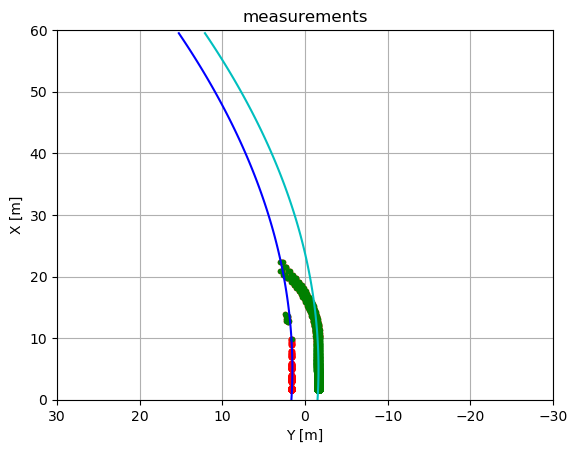

In [ ]:
import time

im = cv2.imread('lane_detection_loop_20.png')
#im = cv2.imread('lane_detection_loop_60.png')
#im = cv2.imread('lane_detection_loop_80.png')

starttime2 = time.perf_counter()
# ==================================================

edges = cv2.Canny(im, 50, 1000)
y, x = np.where(edges > 0)
points = np.column_stack((x, y))


roadPoints = helper.image2road(points)
roadPoints = np.asarray(roadPoints).reshape(-1, 2)

lane_width = 3
roadPoints = roadPoints[
    (roadPoints[:,1] > -lane_width) &
    (roadPoints[:,1] <  lane_width)
]


max_range_m = 25
roi_right_line = np.array([
    [0, 0],
    [6, 0],
    [max_range_m, 8],
    [max_range_m, -15],
    [0, -15] ])

roi_left_line = np.array([
    [0, 0],
    [6, 0],
    [max_range_m, -8],
    [max_range_m, 15],
    [0, 15] ])

M = roadPoints

lane_left = np.empty((0,2))
lane_right = np.empty((0,2))

for i in range(M.shape[0]):
    if cv2.pointPolygonTest(roi_left_line, (M[i,0], M[i,1]), False) > 0:
        lane_left = np.vstack((lane_left, M[i,:]))
    if cv2.pointPolygonTest(roi_right_line, (M[i,0], M[i,1]), False) > 0:
        lane_right = np.vstack((lane_right, M[i,:]))

lane_left_back = helper.road2image(lane_left)
imagePoints_back = np.asarray(lane_left_back).reshape(-1, 2)

lane_right_back = helper.road2image(lane_right)
imagePoints_back = np.asarray(lane_right_back).reshape(-1, 2)

def Cauchy(r, sigma=1):
    """
    Cauchy loss function.

    Args:
        r: resiudals
        sigma: expected standard deviation of inliers

    Returns:
        w: vector of weight coefficients
    """
    ## HIER CODE EINFUEGEN
    c = 2.3849*sigma
    w = 1/(1+((r/c)**2))

    return w
    ## EIGENER CODE ENDE


def MEstimator_lane_fit(pL, pR, Z_initial, sigma=1, maxIteration=10):
    """
    M-Estimator for lane coeffients z=(W, Y_offset, Delta_Phi, c0)^T.

    Args:
        pL: [NL, 2]-array of left marking positions (in DIN70000)
        pR: [NR, 2]-array of right marking positions (in DIN70000)
        Z_initial: the initial guess of the parameter vector
        sigma: the expecvted standard deviation of the inliers
        maxIteration: max number of iterations

    Returns:
        Z: lane coeffients (W, Y_offset, Delta_Phi, c0)
    """

    H = np.zeros((pL.shape[0]+pR.shape[0], 4)) # design matrix
    Y = np.zeros((pL.shape[0]+pR.shape[0], 1)) # noisy observations

    # fill H and Y for left line points
    for i in range(pL.shape[0]):
        u, v = pL[i,0], pL[i,1]
        u2 = u*u
        H[i, :] = [0.5, -1, -u, 1.0/2.0 * u2]
        Y[i] = v

    # fill H and Y for right line points
    for i in range(pR.shape[0]):
        u, v = pR[i,0], pR[i,1]
        u2 = u*u
        u3 = u2*u
        H[pL.shape[0]+i, :] = [-0.5, -1, -u, 1.0/2.0 * u2]
        Y[pL.shape[0]+i] = v

    ## HIER CODE EINFUEGEN
    Z = Z_initial
    for i in range(maxIteration):
        Z = Z.reshape(4,1)
        residual = np.dot(H, Z) - Y
        w = Cauchy(residual, sigma).reshape(-1)
        K_inv = np.diag(w)
        HTKinvH = np.dot(H.T, np.dot(K_inv, H))
        HTKinvY = np.dot(H.T, np.dot(K_inv, Y))
        Z = np.dot(np.linalg.inv(HTKinvH), HTKinvY)

    ## EIGENER CODE ENDE

    return Z


# initial estimate: straight road
Z_initial = np.array([4, 0, 0, 0]).T
0.34491129
# refine initial estimate via M-Estimator
Z_MEst = MEstimator_lane_fit(lane_left, lane_right, Z_initial,
                             sigma=0.4, maxIteration=10)

# ==================================================
stoptime2 = time.perf_counter()
duration = (stoptime2 - starttime2) * 1000

print(f"{duration:.2f} ms")


# draw result
x_pred, yl_pred, yr_pred = LS_lane_compute(Z_MEst)
plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'r.')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'g.')
plt.plot(yl_pred, x_pred, 'b')
plt.plot(yr_pred, x_pred, 'c')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);
print(Z_MEst)
